In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import itertools

import pandas as pd
from scipy.io import savemat, loadmat
import seaborn as sns
from sklearn.metrics import (log_loss, mean_squared_error, roc_curve, auc,
                             precision_recall_fscore_support, confusion_matrix)
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from BEKML import BEMKL
from utils import poly_kernel, gauss_kernel, scoring


heatmap_cmap = matplotlib.colors.ListedColormap(sns.color_palette('rocket').as_hex())

def plot_classification_report(y_test, y_pred, ax=None):
    if ax is None:
        ax = plt.figure(figsize=(8, 8)).gca()

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = list(np.unique(y_test))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_test, y_pred)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    sns.heatmap(rep,
                annot=True, 
                cbar=False, 
                xticklabels=xticks, 
                yticklabels=yticks,
                ax=ax, cmap=heatmap_cmap)
    return


def plot_rocauc(y_test, y_score, ax=None):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    if ax is None:
        ax = plt.figure(figsize=(8, 8)).gca()
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(loc="lower right")
    return


def plot_confusion_matrix(y_test, y_pred, cmap=heatmap_cmap, ax=None):
    """
    This function prints and plots the confusion matrix.
    """
    cm = confusion_matrix(y_test, y_pred)

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    classes = [-1, 1]
    if ax is None:
        ax = plt.figure(figsize=(8, 8)).gca()

    ax_pos = ax.get_position()
    cbar_pos = [
        ax_pos.x0 + ax_pos.width +  0.023,
        ax_pos.y0 + ax_pos.height*0.05,
        ax_pos.width*0.04,
        ax_pos.height - ax_pos.height*0.1,
    ]
    fig = ax.figure
    cax = fig.add_axes(cbar_pos)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(im, cax=cax, orientation='vertical')
    cax.tick_params(labelsize='xx-small', )

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    fmt = '.2f'
    thresh = cm.max() - (cm.max() - cm.min()) * 0.2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black")

    ax.set_ylabel('True label')
    ax.yaxis.set_label_coords(-0.03, 0.5)
    ax.set_xlabel('Predicted label')
    ax.xaxis.set_label_coords(0.5, -0.03)
    return


def plot_metrics(y_true, y_pred, y_scores, axes=None):
    if axes is None:
        _, axes = plt.subplots(3, 1)
    ax1, ax2, ax3 = axes.flatten()
    plot_classification_report(y_test, y_pred, ax=ax1)
    plot_confusion_matrix(y_test, y_pred, ax=ax2)
    plot_rocauc(y_test, y_scores, ax=ax3)


sns.set(style='ticks', context='talk')
np.set_printoptions(precision=4, linewidth=100)

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('data/breast.csv', names=list(range(11)), index_col=0, na_values='?')
display(data.describe())
data = data.dropna()
display(data.head())
data.describe()

,1,2,3,4,5,6,7,8,9,10
count,699.000000,699.000000,699.000000,699.000000,699.000000,683.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.643857,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


,1,2,3,4,5,6,7,8,9,10
0,,,,,,,,,,
1000025,5,1,1,1,2,1.0,3,1,1,2
1002945,5,4,4,5,7,10.0,3,2,1,2
1015425,3,1,1,1,2,2.0,3,1,1,2
1016277,6,8,8,1,3,4.0,3,7,1,2
1017023,4,1,1,3,2,1.0,3,1,1,2


,1,2,3,4,5,6,7,8,9,10
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,2.699854
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.954592
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [3]:
X = data.iloc[:, :-1].values.copy()
y = data.iloc[:, -1].values.copy()
N, D = X.shape
y[y == 2] = -1
y[y == 4] = 1
display(X.shape, y.shape, y.mean())

(683, 9)

(683,)

-0.3001464128843338

In [4]:
rbf_init, rbf_end = -3, 7
ply_init, ply_end = 1, 4

kernel_attrs = [('rbf', 'all', i) for i in range(rbf_init, rbf_end)]
kernels = [lambda A, B: gauss_kernel(A, B, 2**i)
           for i in range(rbf_init, rbf_end)]

kernel_attrs += [('poly', 'all', i) for i in range(ply_init, ply_end)]
kernels += [lambda A, B: poly_kernel(A, B, 1, i)
            for i in range(ply_init, ply_end)]

kernel_attrs += [('rbf', j, i) for i in range(rbf_init, rbf_end)
                 for j in range(D)]
kernels += [lambda A, B: gauss_kernel(A[:, j:j+1], B[:, j:j+1], 2**i)
            for i in range(rbf_init, rbf_end) for j in range(D)]

kernel_attrs += [('poly', j, i) for i in range(ply_init, ply_end)
                 for j in range(D)]
kernels += [lambda A, B: poly_kernel(A[:, j:j+1], B[:, j:j+1], 1, i)
            for i in range(ply_init, ply_end) for j in range(D)]
len(kernels), len(kernel_attrs)

(130, 130)

In [5]:
X_train, X_test, y_train, y_test =\
        train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [6]:
sparse_model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
                     beta_gamma=1, alpha_omega=1, beta_omega=1, e_null_thrsh=1e-3,
                     filter_kernels=False, filter_sv=False, verbose=10)
normalizer = Normalizer()
sparse_pipeline = make_pipeline(normalizer, sparse_model)
sparse_pipeline.fit(X_train, y_train)

Iter: 0. Bound: -411745.62442319316
Iter: 10. Bound: -1450.1358068387628
Iter: 20. Bound: -1375.4441582728705
Iter: 30. Bound: -1341.9866464343186
Iter: 40. Bound: -1329.482812486509
Iter: 50. Bound: -1308.769149646389
Iter: 60. Bound: -1291.259409477811
Iter: 70. Bound: -1285.5760696177788
Iter: 80. Bound: -1279.1712409157108
Iter: 90. Bound: -1267.4985227907591
Iter: 100. Bound: -1257.8390412187969
Iter: 110. Bound: -1247.2426447010457
Iter: 120. Bound: -1243.2142947623672
Iter: 130. Bound: -1239.932081448963
Iter: 140. Bound: -1236.7485181770908
Iter: 150. Bound: -1233.4466882516956
Iter: 160. Bound: -1229.894146582785
Iter: 170. Bound: -1225.942126287215
Iter: 180. Bound: -1221.3529793313462
Iter: 190. Bound: -1215.5735293782864
Iter: 199. Bound: -1207.1766113643412


Pipeline(memory=None,
     steps=[('normalizer', Normalizer(copy=True, norm='l2')), ('bemkl', BEMKL(a_null_thrsh=1e-06, alpha_gamma=1, alpha_lambda=1, alpha_omega=1,
   beta_gamma=1, beta_lambda=1, beta_omega=1, e_null_thrsh=0.001,
   filter_kernels=False, filter_sv=False, init_vars=None,
   k_norm_type='kernel',
   kernels=[...ambda> at 0x7f741f62b1e0>],
   margin=1, max_iter=200, random_state=None, sigma_g=0.1, verbose=10))])

In [7]:
y_pred_proba = sparse_pipeline.predict_proba(X_test)
y_pred = sparse_pipeline.predict(X_test)
y_pred_proba.shape, y_pred.shape

((205, 2), (205,))

In [8]:
Km_train = sparse_model.Km_train
Km_test = sparse_model.Km_test

In [9]:
savemat('Km.mat', {
    'Km_train': Km_train.transpose(1, 2, 0),
    'y_train': y_train,
    'Km_test': Km_test.transpose(2, 1, 0),
    'y_test': y_test,
    'init_vars': sparse_model.init_vars
})

In [10]:
predictions_mat = loadmat('prediction.mat')['prediction'][0, 0]
(predictions_mat['G']['mu'][0, 0].shape, predictions_mat['G']['sigma'][0, 0].shape,
 predictions_mat['f']['mu'][0, 0].shape, predictions_mat['f']['sigma'][0, 0].shape,
 predictions_mat['f']['mu'][0, 0].shape, predictions_mat['f']['sigma'][0, 0].shape,
 predictions_mat['p'].shape)

((130, 205), (130, 205), (205, 1), (205, 1), (205, 1), (205, 1), (205, 1))

In [11]:
display(log_loss(y_test, predictions_mat['p']),
        log_loss(y_test, y_pred_proba))
display(mean_squared_error(y_pred_proba[:, 1].flatten(), predictions_mat['p'].flatten()))

0.44900943307727659

0.44902130446921379

1.3417097206737462e-09

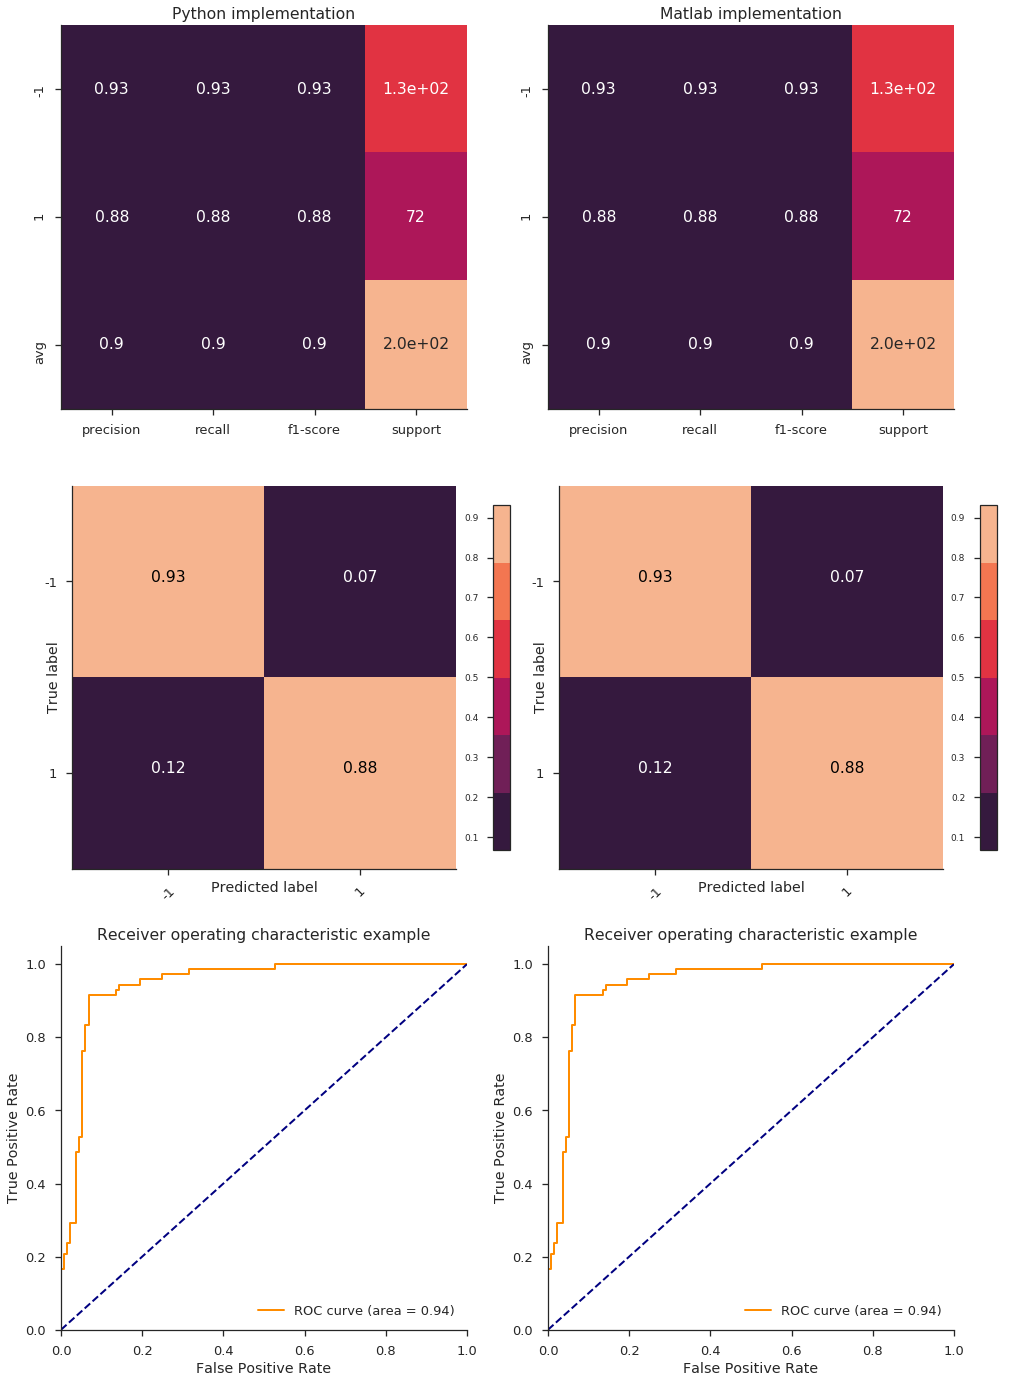

In [12]:
_, axes = plt.subplots(3, 2, figsize=(16, 24))
axes1, axes2 = axes.T

plot_metrics(y_test, y_pred, y_pred_proba[:, 1], axes=axes1)

y_pred_proba_mat = predictions_mat['p']
y_pred_mat = np.ones_like(y_pred_proba_mat)
y_pred_mat[y_pred_proba_mat < 0.5] = -1
plot_metrics(y_test, y_pred_mat, y_pred_proba_mat, axes=axes2)

axes1[0].set_title('Python implementation')
axes2[0].set_title('Matlab implementation')
sns.despine()

In [13]:
from utils import plot_kernel_importances, plot_e_a_mu

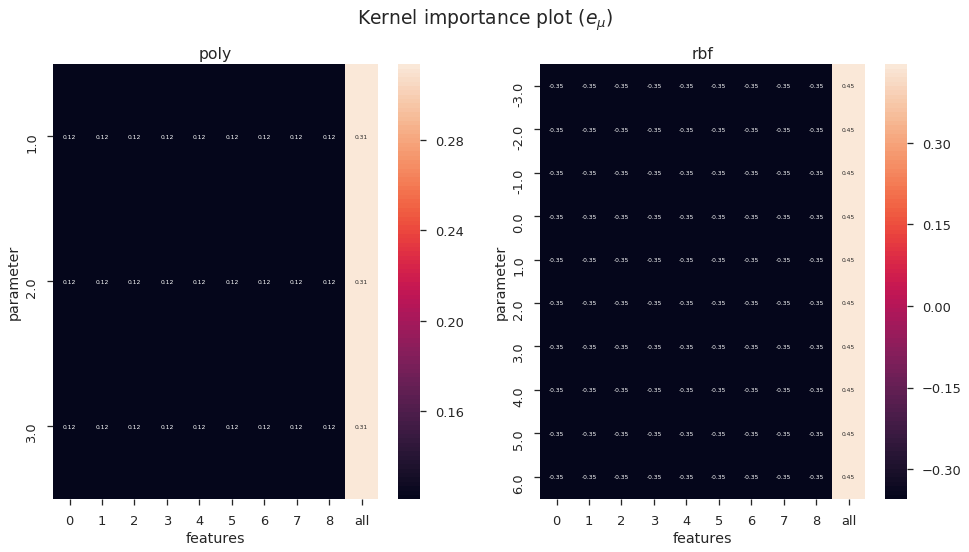

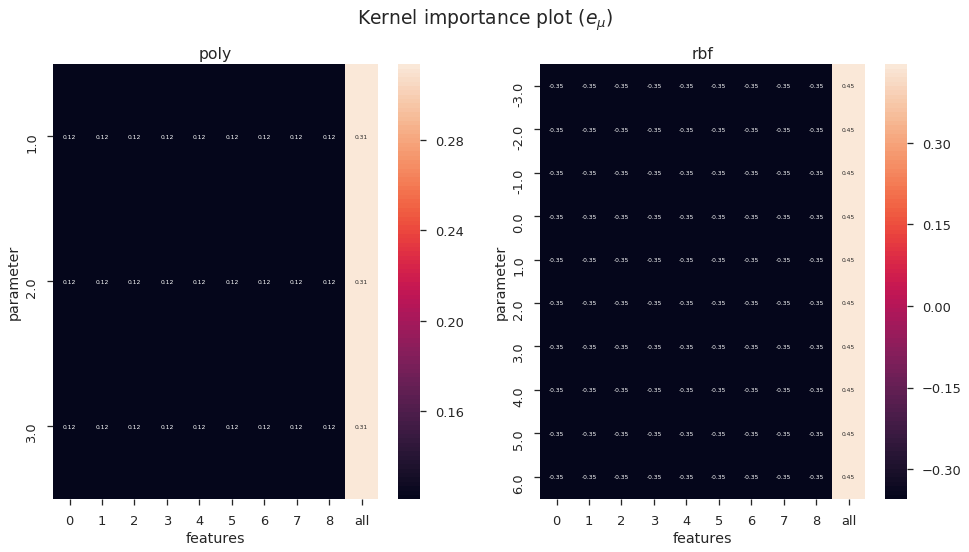

In [14]:
df = pd.DataFrame(np.c_[np.r_[sparse_model.e_mu_orig.flatten(),
                              predictions_mat['be']['mu'][0, 0][1:].flatten()],
                        np.r_[kernel_attrs, kernel_attrs]],
                  columns=['e_mu', 'kernel', 'features', 'parameter'])\
       .astype({'e_mu': float, 'kernel': str,
                'features': str, 'parameter': float})
vmin = df.groupby('kernel').e_mu.min()
vmax = df.groupby('kernel').e_mu.max()

plot_kernel_importances(sparse_model.e_mu_orig, kernel_attrs, vminmax=(vmin, vmax))
plot_kernel_importances(predictions_mat['be']['mu'][0, 0][1:], kernel_attrs, vminmax=(vmin, vmax))